In [23]:
import keras.backend as K
from keras.layers import Input, Add, Dense, Activation, Flatten, Dropout, Conv3D, MaxPooling3D, ZeroPadding3D, AveragePooling3D, TimeDistributed
from keras.models import Model
from keras.regularizers import l1, l2
from keras.optimizers import Adam, SGD
from keras.constraints import max_norm
from keras.layers.noise import GaussianNoise
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix, f1_score
import operator
import matplotlib.pyplot as plt
import config
import importlib
import os
import numpy as np
import tensorflow as tf
%matplotlib inline

from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

nb_classes = C.nb_classes

X_train = np.expand_dims(x_train,axis=3)
X_train = np.expand_dims(X_train,axis=4)
X_test = np.expand_dims(x_test,axis=3)
X_test = np.expand_dims(X_test,axis=4)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [15]:
importlib.reload(config)

<module 'config' from 'C:\\Users\\Clinton\\Documents\\voi-classifier\\config.py'>

In [86]:
C = config.Config()
dims = C.dims
voi_img = Input(shape=(dims[0], dims[1], dims[2], C.nb_channels))
x = voi_img
#x = Dropout(0.2)(x)
#x = GaussianNoise(1)(x)
#x = ZeroPadding3D(padding=(3,3,2))(voi_img)
#x = Conv3D(filters=128, kernel_size=(3,3,2), activation='relu')(x)
x = Conv3D(filters=32, kernel_size=(3,3,1), activation='relu')(x)
#x = Dropout(0.5)(x)
x = MaxPooling3D((2, 2, 1))(x)
x = Conv3D(filters=64, kernel_size=(3,3,2), activation='relu')(x)
x = Dropout(0.5)(x)
#x = Conv3D(filters=128, kernel_size=(2,2,2), activation='relu')(x)
x = MaxPooling3D((2, 2, 2))(x)
x = Flatten()(x)
x = Dense(164, activation='relu')(x)#, kernel_initializer='normal', kernel_regularizer=l1(.01), kernel_constraint=max_norm(3.))(x)
x = Dropout(0.5)(x)
pred_class = Dense(C.nb_classes, activation='softmax')(x)#Dense(C.nb_classes, activation='softmax')(x)

In [87]:
optim = Adam(lr=0.01)#, decay=0.001)
early_stopping = EarlyStopping(min_delta=0.001, patience=10)

model = Model(voi_img, pred_class)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 24, 24, 12, 1)     0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 22, 22, 12, 32)    320       
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 11, 11, 12, 32)    0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 9, 9, 11, 64)      36928     
_________________________________________________________________
dropout_34 (Dropout)         (None, 9, 9, 11, 64)      0         
_________________________________________________________________
max_pooling3d_22 (MaxPooling (None, 4, 4, 5, 64)       0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 5120)              0         
__________

model2 = Model(voi_img, intermed)

for l in range(2,len(model2.layers)):
    model2.layers[l].set_weights(model.layers[l].get_weights())

X_train = []
Y_train = []

for _ in range(10):
    X_train.append(np.ones(dims + [C.nb_channels]))
    Y_train.append([1,0])
for _ in range(10):
    X_train.append(np.ones(dims + [C.nb_channels]))
    X_train[-1][5:15,5:15,5:7,0] = 2
    Y_train.append([0,1])
    
X_train = np.array(X_train) # X[:total_size//2]
#X_val = np.array(X_test)
Y_train = np.array(Y_train) # Y[:total_size//2]
#Y_val = np.array(Y_test)

In [88]:
orig_data_dict = {}
num_samples = {}
    
for class_name in os.listdir(C.orig_dir):
    x = np.empty((10000, dims[0], dims[1], dims[2], C.nb_channels))
    z = []
    
    for index, img_fn in enumerate(os.listdir(C.orig_dir+class_name)):
        try:
            x[index] = np.load(C.orig_dir+class_name+"\\"+img_fn)
        except:
            raise ValueError(C.orig_dir+class_name+"\\"+img_fn + " not found")
        z.append(img_fn)
    
    x.resize((index, dims[0], dims[1], dims[2], C.nb_channels)) #shrink first dimension to fit
    orig_data_dict[class_name] = [x,np.array(z)]
    num_samples[class_name] = index

In [89]:
num_samples

{'cyst': 22, 'fnh': 58, 'hcc': 54, 'hemangioma': 53}

In [90]:
train_ids = {} #filenames of training set originals
test_ids = {} #filenames of test set
X_test = []
Y_test = []
Z_test = []
cls_mapping = []

train_frac = {"cyst": 0.7, "fnh": 0.7, "hcc": 0.7, "hemangioma": 0.7}
train_samples = {}

for cls_num, cls in enumerate(orig_data_dict):
    train_samples[cls] = round(num_samples[cls]*train_frac[cls])
    
    order = np.random.permutation(list(range(num_samples[cls])))
    train_ids[cls] = list(orig_data_dict[cls][1][order[:train_samples[cls]]])
    test_ids[cls] = list(orig_data_dict[cls][1][order[train_samples[cls]:]])
    X_test = X_test + list(orig_data_dict[cls][0][order[train_samples[cls]:]])
    Y_test = Y_test + [[0] * cls_num + [1] + [0] * (C.nb_classes - cls_num - 1)] * \
                        (num_samples[cls] - train_samples[cls])
    Z_test = Z_test + list(orig_data_dict[cls][1][order[train_samples[cls]:]])
    cls_mapping.append(cls)
    
    print("%s has %d samples for training (%d after augmentation) and %d for testing" %
          (cls, train_samples[cls], train_samples[cls] * C.aug_factor, num_samples[cls] - train_samples[cls]))

fnh has 41 samples for training (1640 after augmentation) and 17 for testing
hcc has 38 samples for training (1520 after augmentation) and 16 for testing
cyst has 15 samples for training (600 after augmentation) and 7 for testing
hemangioma has 37 samples for training (1480 after augmentation) and 16 for testing


In [81]:
aug_data_dict = {}

for class_name in os.listdir(C.aug_dir):
    x_train = np.empty((10000, dims[0], dims[1], dims[2], C.nb_channels))
    x_val = np.empty((10000, dims[0], dims[1], dims[2], C.nb_channels))
    z = []
    
    train_cnt = 0
    val_cnt = 0
    for img_fn in os.listdir(C.aug_dir+class_name):
            
        if "_".join(img_fn.split("_")[:2])+".npy" in train_ids[class_name]:
            try:
                x_train[train_cnt] = np.load(C.aug_dir+class_name+"\\"+img_fn)
            except:
                raise ValueError(C.aug_dir+class_name+"\\"+img_fn + " cannot be loaded")
            train_cnt += 1
            z.append(img_fn)
            
        else:
            try:
                x_val[val_cnt] = np.load(C.aug_dir+class_name+"\\"+img_fn)
            except:
                raise ValueError(C.aug_dir+class_name+"\\"+img_fn + " cannot be loaded")
            val_cnt += 1
    
    x_train.resize((train_cnt, dims[0], dims[1], dims[2], C.nb_channels)) #shrink first dimension to fit
    x_val.resize((val_cnt, dims[0], dims[1], dims[2], C.nb_channels)) #shrink first dimension to fit
    aug_data_dict[class_name] = {'train': [x_train,np.array(z)], 'val': x_val}

In [82]:
X_train = []
Y_train = []
Z_train = []
X_val = []
Y_val = []
Z_val = []

for cls_num, cls in enumerate(aug_data_dict):
    X_train = X_train + list(aug_data_dict[cls]['train'][0])
    Y_train = Y_train + [[0] * cls_num + [1] + [0] * (C.nb_classes - cls_num - 1)] * len(aug_data_dict[cls]['train'][0])
    Z_train = Z_train + list(aug_data_dict[cls]['train'][1])
    
    X_val = X_val + list(aug_data_dict[cls]['val'])
    Y_val = Y_val + [[0] * cls_num + [1] + [0] * (C.nb_classes - cls_num - 1)] * len(aug_data_dict[cls]['val'])

Z_cyst = data_dict["cyst"][1]

Y_[-4]

Z_cyst[-4]

X_cyst = data_dict["cyst"][0]
X_cyst = np.array(X_cyst) # X[:total_size//2]
X_cyst /= 255

X_hcc = data_dict["hcc"][0]
X_hcc = np.array(X_hcc) # X[:total_size//2]
X_hcc /= 255

In [83]:
X_train = np.array(X_train) / 255 # X[:total_size//2]
X_val = np.array(X_val) / 255
X_test = np.array(X_test) / 255
Y_train = np.array(Y_train)
Y_val = np.array(Y_val)
Z_train = np.array(Z_train)
Z_test = np.array(Z_test)

In [84]:
print(len(Y_train), len(Y_val), len(Y_test))

4420 2040 56


In [264]:
#X = np.array([z for z in x])
#Y = np.array(y)
#Y = np.array([[0,1] if y[x] == 1 else [1,0] for x in range(len(y))])
#Y = K.constant(y, dtype=tf.int32)
#Y = K.one_hot(Y, C.nb_classes)

#total_size = X.shape[0]

#order = np.random.permutation(list(range(total_size)))
#X = X[order]
#Y = Y[order]

def train_generator(X, Y):
    while True:
        for i in range(len(X)):
            yield np.expand_dims(X[i], axis=0), np.expand_dims(Y[i], axis=0)

num_epochs = 10
epoch_length = 100
best_loss = np.Inf
losses = np.zeros(epoch_length)
acc = np.zeros(epoch_length)

data_gen_train = train_generator(X_train, Y_train)
for epoch_num in range(num_epochs):
    print('Epoch {}/{}'.format(epoch_num + 1, num_epochs))
    iter_num = 0
    
    while True:
        X, Y = next(data_gen_train)
        losses[iter_num], acc[iter_num] = model.train_on_batch(X, Y)

        iter_num += 1
        if iter_num == epoch_length:
            curr_loss = np.mean(losses)
            curr_acc = np.mean(acc)
            print("Mean Loss:", curr_loss, "// Mean Accuracy:", curr_acc)

            if curr_loss < best_loss:
                print('Total loss decreased from {} to {}, saving weights'.format(best_loss,curr_loss))
                best_loss = curr_loss
                model.save_weights(C.model_path)
            break

In [91]:
hist = model.fit(X_train, Y_train, batch_size=128, epochs=200, validation_data=(X_val, Y_val)) #callbacks=[early_stopping]

Train on 4420 samples, validate on 2040 samples
Epoch 1/200
4420/4420 [==============================] - 2s - loss: 1.3072 - acc: 0.3652 - val_loss: 1.3065 - val_acc: 0.3284
Epoch 2/200
4420/4420 [==============================] - 2s - loss: 1.1986 - acc: 0.4538 - val_loss: 1.2967 - val_acc: 0.3598
Epoch 3/200
4420/4420 [==============================] - 2s - loss: 1.1158 - acc: 0.5090 - val_loss: 1.2509 - val_acc: 0.4225
Epoch 4/200
4420/4420 [==============================] - 2s - loss: 1.0421 - acc: 0.5475 - val_loss: 1.2154 - val_acc: 0.4328
Epoch 5/200
4420/4420 [==============================] - 2s - loss: 0.9748 - acc: 0.5862 - val_loss: 1.2112 - val_acc: 0.4618
Epoch 6/200
4420/4420 [==============================] - 2s - loss: 0.9246 - acc: 0.6020 - val_loss: 1.1742 - val_acc: 0.4583
Epoch 7/200
4420/4420 [==============================] - 2s - loss: 0.8887 - acc: 0.6249 - val_loss: 1.1713 - val_acc: 0.4706
Epoch 8/200
4420/4420 [==============================] - 2s - loss: 0.

KeyboardInterrupt: 

In [15]:
Y_pred = model.predict(X_val)
y_true = [max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_val]
y_pred = [max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_pred]

cm = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
Z_val

In [19]:
y_pred

[0, 0, 3, 3, 0, 0, 3, 0, 0, 0, 2, 0, 3, 2, 0, 0, 3, 3, 3, 0, 3, 3, 3]

In [20]:
y_true

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

In [21]:
cls_mapping

['fnh', 'hcc', 'cyst', 'hemangioma', 'fnh', 'hcc', 'cyst', 'hemangioma']

In [16]:
cm

array([[5, 0, 0, 3],
       [2, 0, 0, 0],
       [1, 0, 1, 1],
       [3, 0, 1, 6]], dtype=int64)

In [42]:
f1

0.8957638504141382

In [153]:
Y_val[1000]

array([0, 0, 0, 1])

In [127]:
model.predict(X_cyst)

array([[  4.70719121e-15,   1.00000000e+00],
       [  5.68544777e-14,   1.00000000e+00],
       [  1.99857548e-18,   1.00000000e+00],
       [  1.62834822e-05,   9.99983668e-01],
       [  2.65297940e-11,   1.00000000e+00],
       [  3.26242852e-12,   1.00000000e+00],
       [  4.11501969e-06,   9.99995828e-01],
       [  1.92551225e-10,   1.00000000e+00],
       [  6.02835673e-04,   9.99397159e-01],
       [  2.27131158e-09,   1.00000000e+00],
       [  4.50570951e-05,   9.99954939e-01],
       [  5.96788668e-05,   9.99940276e-01],
       [  5.31585003e-14,   1.00000000e+00],
       [  6.96933782e-08,   9.99999881e-01],
       [  1.58653242e-13,   1.00000000e+00],
       [  1.53077719e-26,   1.00000000e+00],
       [  2.25973595e-02,   9.77402627e-01],
       [  4.77840245e-01,   5.22159815e-01],
       [  2.87815639e-11,   1.00000000e+00],
       [  1.31480746e-28,   1.00000000e+00],
       [  1.57597730e-12,   1.00000000e+00],
       [  1.88092380e-12,   1.00000000e+00]], dtype=flo

In [159]:
activ = model2.predict(X_train)
#activ = model2.predict(np.expand_dims(X_train[10],axis=0))

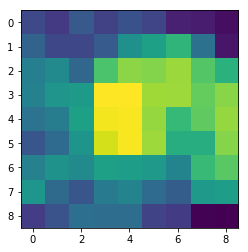

In [166]:
plt.imshow(activ[20][:,:,3,5])

In [162]:
activ[0][5,5,2,:]

array([   0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,  121.71251678,   53.23372269,    0.        ,
          0.        ,   24.43340492,    0.        ,    0.        ,
          0.        ,    0.        ,    7.88301706,    0.        ], dtype=float32)

In [113]:
Z_val[::30]

array(['12296182_23.npy', '13028374_2.npy', 'E104657225_14.npy',
       '12972894_6.npy'],
      dtype='<U17')

In [133]:
Y_[-5]

array([ 0.47784024,  0.52215981], dtype=float32)

In [162]:
143/(143+18)

0.8881987577639752

In [ ]:
(15+6+7)/

In [144]:
import operator
#print("Ground truth:", [cls_mapping[max(enumerate(x), key=operator.itemgetter(1))[0]] for x in Y_val[::30]])
Y_ = model.predict(X_cyst)
print("Predictions:", [cls_mapping[max(enumerate(x), key=operator.itemgetter(1))[0]] + " (%.5f%% confidence)" % (max(x)*100) for x in Y_])

Predictions: ['cyst (100.00000% confidence)', 'cyst (100.00000% confidence)', 'cyst (100.00000% confidence)', 'cyst (99.99998% confidence)', 'cyst (100.00000% confidence)', 'cyst (100.00000% confidence)', 'cyst (100.00000% confidence)', 'cyst (100.00000% confidence)', 'cyst (99.99858% confidence)', 'cyst (100.00000% confidence)', 'cyst (99.99996% confidence)', 'cyst (99.99999% confidence)', 'cyst (100.00000% confidence)', 'cyst (100.00000% confidence)', 'cyst (100.00000% confidence)', 'cyst (100.00000% confidence)', 'cyst (99.60698% confidence)', 'hcc (70.35562% confidence)', 'cyst (100.00000% confidence)', 'cyst (100.00000% confidence)', 'cyst (100.00000% confidence)', 'cyst (100.00000% confidence)']


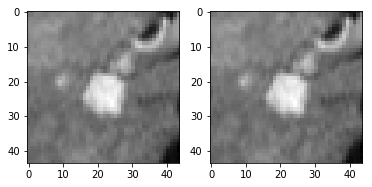

In [147]:
import pandas as pd
voi_df = pd.read_csv('..\\liver-mr-processor\\vois.csv')
img_fn = "12972894.npy"
img = np.load("..\\liver-mr-processor\\full_imgs\\"+img_fn)
plot_section(img, voi_df[voi_df["Filename"] == img_fn].iloc[0], pad=15)

In [136]:
def plot_section(img, df, pad=30):
    plt.subplot(121)
    plt.imshow(np.transpose(img[df['x1']-pad:df['x2']+pad,
                                df['y2']+pad:df['y1']-pad:-1,
                                (df['z1']+df['z2'])//2, 0], (1,0)), cmap='gray')
    plt.subplot(122)
    plt.imshow(np.transpose(img[df['x1']-pad:df['x2']+pad,
                                df['y2']+pad:df['y1']-pad:-1,
                                (df['z1']+df['z2'])//2, 1], (1,0)), cmap='gray')

In [20]:
Y_[-1]

array([  2.78843247e-04,   9.99721110e-01], dtype=float32)

In [19]:
max(sum(y)/len(y), 1-sum(y)/len(y))

0.6875

In [87]:
len(X_val)

210

In [84]:
import time

In [86]:
a=time.time()
Y_ = model.predict(X_val)
print(time.time()-a)

0.20054101943969727


In [136]:
import matplotlib.pyplot as plt
%matplotlib inline

In [150]:
np.amax(X[650,:,:,:,0])

0.0

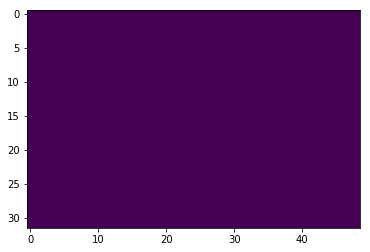

In [140]:
plt.imshow(X[0,:,:,5,0])